<a href="https://colab.research.google.com/github/kaggler-KyotoUni/kaggle-m5forecasting/blob/kasa_branch/%E3%80%90%E6%97%A5%E6%9C%AC%E8%AA%9E%E3%80%91Starter_Data_Exploration_%E3%81%A8_LSTM_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

日本人の方が始めやすいように、日本語訳や解説を付け加えたものになります。
(こちらのnotebook)[https://www.kaggle.com/robikscube/m5-forecasting-starter-data-exploration]をベースにしています。
自分なりの分析やmodelなどを追加していく予定です。

# M5 Forecasting Challenge
<img src="https://images.ctfassets.net/osv85d77hkdf/7LsZ5bZzvGaG6iwYkoKEUc/84afe0bf84371542fe56e6d5f0b3377b/hero_telescope_01_2x.png" width="500" height="300" />

The goal of this notebook is to give competitors a quick overview of the 2020 M5 competition. After reading it you should have a good idea of the objective you are trying to solve, the data provided and the metrics you will be scored on.

Some tl;dr items to note:
- There are two parallel competitions: **Accuracy** and **Uncertainty**
    - The accuracy competition will use the metric: **Weighted Root Mean Squared Scaled Error** (RMSSE)
    - The uncertainty competition will use the metric: **Weighted Scaled Pinball Loss** (WSPL)
- We are tasked with forecasting hierarchical sales data from Wal-Mart.
- The data, covers stores in three US States (California, Texas, and Wisconsin) and includes item level, department, product categories, and store details.
- In addition, it has explanatory variables such as price, promotions, day of the week, and special events.

このnotebookの目的は参加者にM5コンペの概要をざっと理解してもらう事にあります。
読み終える頃には「コンペの目標」、「データの概要」、「評価指標」などを理解できている事でしょう。

以下にコンペのdescriptionを要約した物を箇条書きしておきます。
- 並行して二つのコンペが実施されています。こちらはAccuracyでもう片方はUncertaintyです。
　- accuracyコンペはWeighted Root Mean Squared Scaled Error (RMSSE)を指標にしています。
　- uncertaintyコンペはWeighted Scaled Pinball Loss (WSPL)を指標にしています。
- 今回のコンペはwal-martの売り上げを予測することが目標です。
- データには、州名、商品の--、部署、品目、店舗の詳細などが含まれています。
- これらに加えて、価格や広告、曜日やイベントなどの説明変数もまた含まれています。

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from itertools import cycle
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Files
- `calendar.csv` - Contains information about the dates on which the products are sold.
- `sales_train_validation.csv` - Contains the historical daily unit sales data per product and store [d_1 - d_1913]
- `sample_submission.csv` - The correct format for submissions. Reference the Evaluation tab for more info.
- `sell_prices.csv` - Contains information about the price of the products sold per store and date.

Not available yet:
- `sales_train_evaluation.csv` - Available one month before competition deadline. Will include sales [d_1 - d_1941]

各データファイルの説明
- calendar.csv その日のイベント、イベント種別、曜日など日付に紐づいたデータが記載されています。
- sales_train_validation.csv 商品毎と店毎に分けたの売り上げ数を表している。(state_idはstore_idから一意に定まる、これはitem_id→dept_id, cat_idも同じ。)
- sample_submission.csv 予測結果として提出するcsvの例
- sell_prices.csv その商品の店と日付ごとの価格

In [0]:
!ls -GFlash --color ../input/m5-forecasting-accuracy/

ls: cannot access '../input/m5-forecasting-accuracy/': No such file or directory


In [0]:
# Read in the data
INPUT_DIR = '/content/drive/My Drive/M5_data'
cal = pd.read_csv(f'{INPUT_DIR}/calendar.csv')
stv = pd.read_csv(f'{INPUT_DIR}/sales_train_validation.csv')
ss = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')
sellp = pd.read_csv(f'{INPUT_DIR}/sell_prices.csv')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# What exactly are we trying to predict?
We are trying for forecast sales for 28 forecast days. The sample submission has the following format:
- The columns represent 28 forecast days. We will fill these forecast days with our predictions.
- The rows each represent a specific item. This id tells us the item type, state, and store. We don't know what these items are exactly.

何を予測しようとしているのかについて考えていく。
このコンペを通じて、予測しようとしているのは28日分の売上です。提出のサンプルから次のようなフォーマットで予想すればいい事がわかります。

- それぞれの列はこれから先の28日を1日ごとに示しています。今回はこれを埋めていく事になります。
- それぞれの行は特定の商品を表しています。idによって商品の種別や州、店名までは特定することができます。しかし、どの品目であるのか一意に定めることはできません。
(注釈　つまりこれは東京都の新宿店の清涼飲料水の売上である事までは特定できても、コカコーラの売上であるというところまでは特定できないという事です。)

In [0]:
ss.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


We are given historic sales data in the `sales_train_validation` dataset.
- rows exist in this dataset for days d_1 to d_1913. We are given the department, category, state, and store id of the item.
- d_1914 - d_1941 represents the `validation` rows which we will predict in stage 1
- d_1942 - d_1969 represents the `evaluation` rows which we will predict for the final competition standings.

sales_train_validation.csvから、売上の時系列データを得ることができます。

- それぞれの列は1日目から1913日目までの売上数を保持しています。また、その商品の部門名とカテゴリー名もデータに含まれています。それぞれの商品の売上を店毎に行を分けているため、店名とその店の存在する州名も保持しています。
- stage1では1914日目から1941日目までの予測を行います。
- このコンペの最終評価は1942日目から1969日目までの予測結果に基づいて行います。

In [0]:
stv.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


# Visualizing the data for a single item
- Lets take a random item that sell a lot and see how it's sales look across the training data.
- `FOODS_3_090_CA_3_validation` sells a lot
- Note there are days where it appears the item is unavailable and sales flatline

商品を選んで、そのデータを可視化してみる。

- まずはよく売れている商品からランダムに選択してその商品が訓練用データセットにおいてどのように推移しているかを見ていく事にする。
- FOODS_3_090_CA_3_validationがよく売れているようなので、これにする。
- 商品が未発売であるためグラフ上で平行に推移している可能性があるので、注意してください。

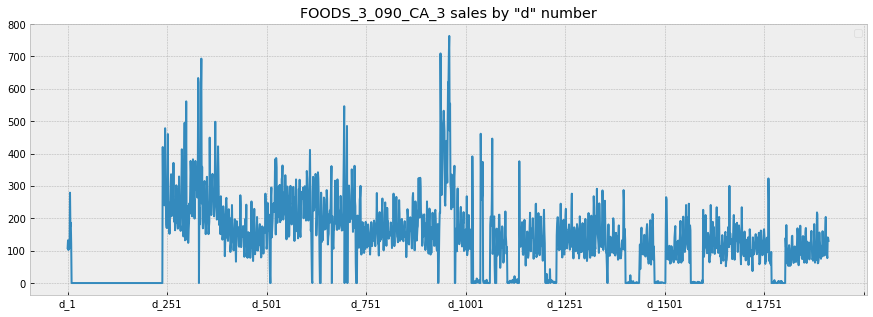

In [0]:
d_cols = [c for c in stv.columns if 'd_' in c] # sales data columns
# d_がカラム名に含まれているカラムのみ抽出して配列として保持

# Below we are chaining the following steps in pandas:
# 下のメソッドチェーンでは以下に示すデータ処理をpandasで行なっています。
# 1. Select the item.
# 商品の絞り込みを行います。
# 2. Set the id as the index, Keep only sales data columns
# idについてはindexとして保持するようにします。また、d_とつくカラムのみにデータを絞っています。
# 3. Transform so it's a column
# このままでは行なので、列に変えます。(一行を転置して一列にしている。)
# 4. Plot the data
# プロットしている。
stv.loc[stv['id'] == 'FOODS_3_090_CA_3_validation'] \
    .set_index('id')[d_cols] \
    .T \
    .plot(figsize=(15, 5),
          title='FOODS_3_090_CA_3 sales by "d" number',
          color=next(color_cycle))
plt.legend('')
plt.show()



ぱっと見ですが、下の様なことが予想できます。
- d_1からd_251は上で注意点として述べたように、この商品が未発売であるため、売上が0として計上されている可能性が高いです。
- 何度かスパイクがあるので、そこに絞ってカレンダーを注視してみるのが良さそうです。
- 周期的に売上が変動しているように見えるので曜日毎、日付ごとなどデータの集計方式を変える事に意味がありそう。

## Merging the data with real dates
- We are given a calendar with additional information about past and future dates.
- The calendar data can be merged with our days data
- From this we can find weekly and annual trends

訓練用データをカレンダーcsvとマージしてみる。

- calendar.csvは過去の日付から未来の日付まで用意してあります。
- calendar.csvはstvのdaysデータとjoinする事ができる。
- joinする事によって、週毎、年毎のトレンドをみる事ができる。

In [0]:
# Calendar data looks like this (only showing columns we care about for now)
# カレンダーcsvはこの様な見た目をしています。
cal[['d','date','event_name_1','event_name_2',
     'event_type_1','event_type_2', 'snap_CA']].head()

,d,date,event_name_1,event_name_2,event_type_1,event_type_2,snap_CA
0,d_1,2011-01-29,NaN,NaN,NaN,NaN,0
1,d_2,2011-01-30,NaN,NaN,NaN,NaN,0
2,d_3,2011-01-31,NaN,NaN,NaN,NaN,0
3,d_4,2011-02-01,NaN,NaN,NaN,NaN,1
4,d_5,2011-02-02,NaN,NaN,NaN,NaN,1


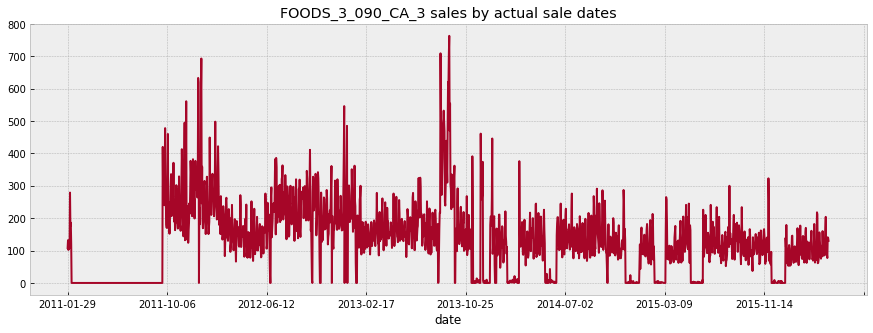

In [0]:
# Merge calendar on our items' data
# ここから、カレンダーcsvをstv(商品データ)にjoinしていく。
example = stv.loc[stv['id'] == 'FOODS_3_090_CA_3_validation'][d_cols].T
#↑先ほどのメソッドチェーンと同様の処理を行なっている。
example = example.rename(columns={8412:'FOODS_3_090_CA_3'}) # Name it correctly
#indexがカラム名になっていたので、それを商品IDに変更
example = example.reset_index().rename(columns={'index': 'd'}) # make the index "d"
#indexを新たに付与
example = example.merge(cal, how='left', validate='1:1')
#↑ここで、calendarとjoinする。
example.set_index('date')['FOODS_3_090_CA_3'].plot(figsize=(15, 5),
                                                   color=next(color_cycle),
                                                   title='FOODS_3_090_CA_3 sales by actual sale dates')
plt.show()

上の様に、日付表示する事ができる様になった。

# Sales broken down by time variables
- Now that we have our example item lets see how it sells by:
    - Day of the week
    - Month
    - Year

売り上げを各日付に紐づいた変数に基づいて集計し直していきます。
これから以下の日付指標に基づいて、FOODS_3_090_CA_3の分析を行なっていきたいと思います。
- 曜日
- 月
- 年

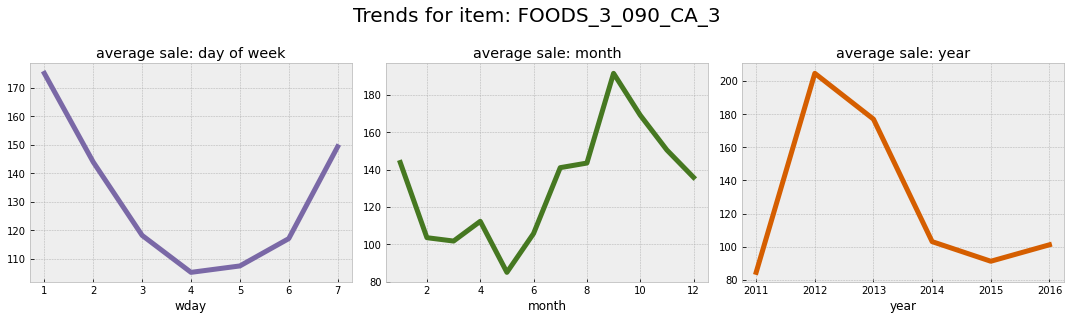

In [0]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
example.groupby('wday').mean()['FOODS_3_090_CA_3'] \
    .plot(kind='line',
          title='average sale: day of week',
          lw=5,
          color=next(
              color_cycle),
          ax=ax1)
#↑曜日で一括りにして平均をとる
example.groupby('month').mean()['FOODS_3_090_CA_3'] \
    .plot(kind='line',
          title='average sale: month',
          lw=5,
          color=next(
               color_cycle),

          ax=ax2)
#↑月で一括りにして平均をとる
example.groupby('year').mean()['FOODS_3_090_CA_3'] \
    .plot(kind='line',
          lw=5,
          title='average sale: year',
          color=next(
              color_cycle),

          ax=ax3)
#↑年で一括りにして平均をとる
fig.suptitle('Trends for item: FOODS_3_090_CA_3',
             size=20,
             y=1.1)
plt.tight_layout()
plt.show()

- 曜日による差がある事がわかった。
ただし曜日で生じる差が商品の特性によるものなのか、スーパーマーケットの訪問者数によるものなのかまだ判断がつかない。
(例えば商品がステーキ肉であった場合、週末はステーキを食べる傾向にあるのか、それとも週末に多くの家族が買い出しにくる傾向にあるのかがわからない。)
- 月により差があることがわかった
スーパーの訪問者数が一定であると考えると、二倍程度の差が出ているので、旬や収穫時期が明確に存在するものである可能性がある。もしくはハロウィン→カボチャのように季節のイベントと密接に関わりのあるものであることが想像できる。
もしくはスーパーの訪問者数が一定でない可能性もある。例えばビーチの近くのお店だった場合、夏に観光客が多いため訪問者数の増加に従って商品の売り上げも伸びている。
つまり、商品のもつトレンドではなく、州や店舗のもつトレンドである可能性もある。
- 年により差があることがわかった
単にこの店舗が2011年にオープンで物珍しさから2,3年の訪問者数が多かった可能性がある。また、店舗の商品の値段の推移などから経営方針に影響を受けている可能性も加味できる。

# Lets look at a lot of different items!
- Lets put it all together to plot 20 different items and their sales
- Some observations from these plots:
    - It is common to see an item unavailable for a period of time.
    - Some items only sell 1 or less in a day, making it very hard to predict.
    - Other items show spikes in their demand (super bowl sunday?) possibly the "events" provided to us could help with these.

それでは他の商品についても見ていきましょう。
- 20個ほど商品を選んで、それらの売上を上と同様に集計します。
※↓以下データから得られた情報に基づいての記述です。
- グラフのデータについていくつか中止すべき点があります。
 - ある期間、商品が売られていない事がある。
 - 1日に売れる数が多くても1個の様な商品は予測することが難しい。
 - (多くても1日に一個しか売れない商品以外では)スパイク(その部分だけ売上が異常に多い事)が観測できる。(おそらくsuper bowl(アメリカのビッグイベント)のある日曜日?)スパイクの起きている日については、calendar.csvのevent dataを見れば良い知見が得られそう。

In [0]:
twenty_examples = stv.sample(20, random_state=529) \
        .set_index('id')[d_cols] \
    .T \
    .merge(cal.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')
# 20個抽出しています。

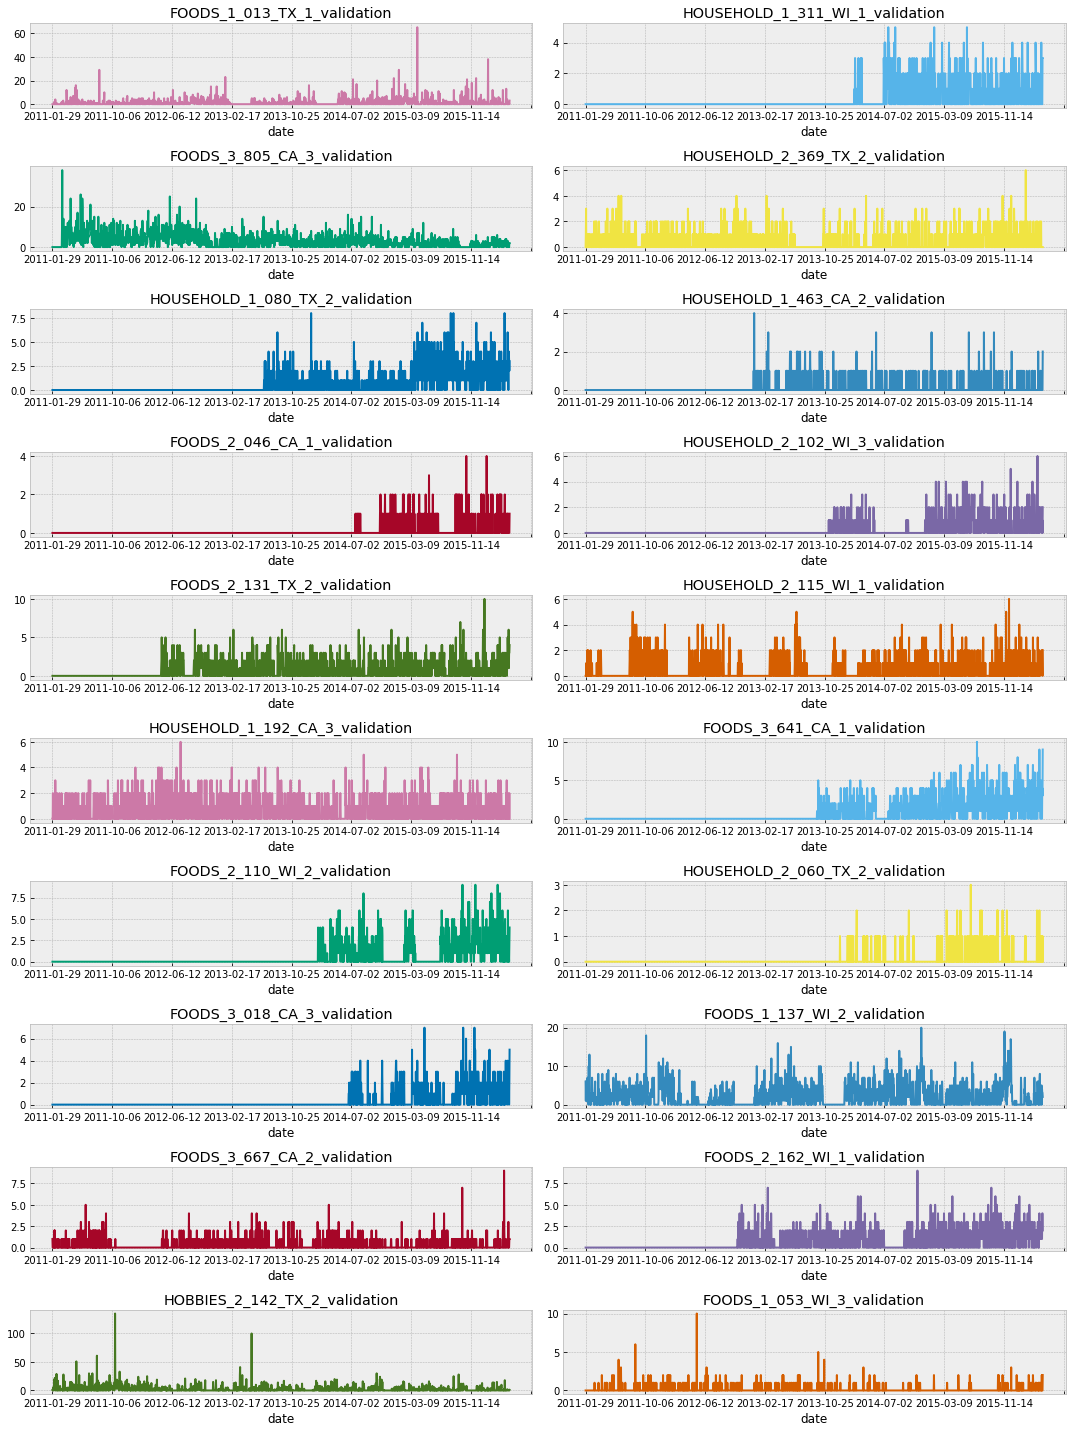

In [0]:
fig, axs = plt.subplots(10, 2, figsize=(15, 20))
axs = axs.flatten()
ax_idx = 0
for item in twenty_examples.columns:
    twenty_examples[item].plot(title=item,
                              color=next(color_cycle),
                              ax=axs[ax_idx])
    ax_idx += 1
plt.tight_layout()
plt.show()
# それぞれの商品毎にデータを表示しています。

# Combined Sales over Time by Type
- We have several item types:
    - Hobbies
    - Household
    - Foods
- Lets plot the total demand over time for each type

売上の時系列データを商品のタイプごとに分けて見ていきましょう。
- 与えられたデータには以下の様な商品タイプがありました。
  - 娯楽品
  - 生活必需品
  - 食料品
- それぞれの商品タイプについてデータを集計し、グラフに表示していきたいと思います。

In [0]:
stv['cat_id'].unique()

array(['HOBBIES', 'HOUSEHOLD', 'FOODS'], dtype=object)

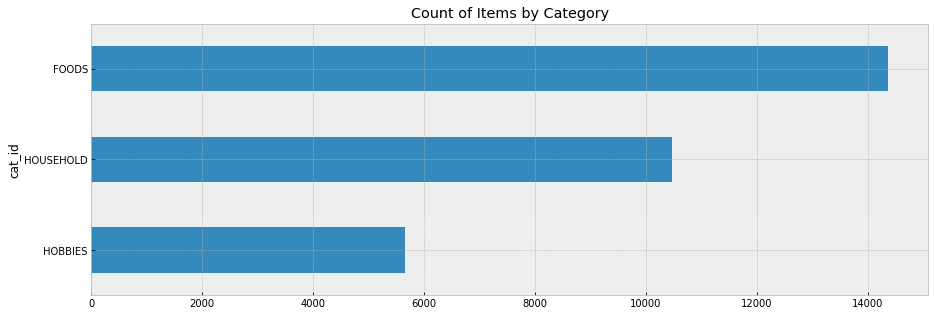

In [0]:
stv.groupby('cat_id').count()['id'] \
    .sort_values() \
    .plot(kind='barh', figsize=(15, 5), title='Count of Items by Category')
plt.show()
# カテゴリー毎の品目数を表示

ここは僕のコメントです。
日本のスーパーを想像するとほとんどが食品であり、少しだけ日用品が売られていて、娯楽用品などはほとんど無いと思います。
日本のスーパー基準だと、順位については納得できるものである様に感じますが、foodと他との品目数の差が思ったより開いていないことを疑問に感じます。
これはwalmartが食品や日用品から携帯電話やゲームまで幅広く揃えている超大型スーパーであるからです。
日本だとイオンモールなどの大型ショッピングモールを想像するとイメージが近づけれるのでは無いかと思います。

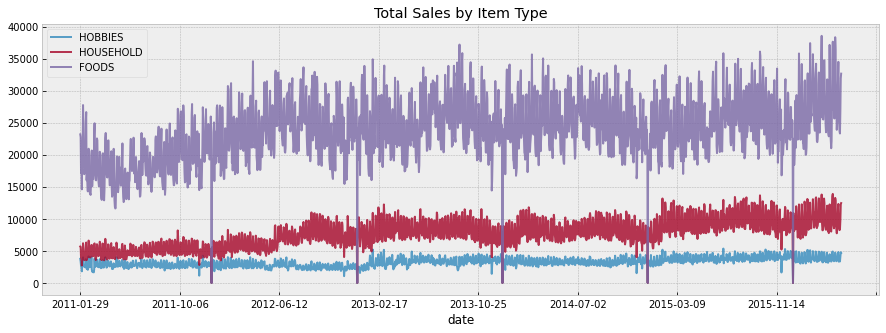

In [0]:
past_sales = stv.set_index('id')[d_cols] \
    .T \
    .merge(cal.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')
# 商品のデータを上の処理と同じように転置して、日付データとjoinしています。
for i in stv['cat_id'].unique():
    items_col = [c for c in past_sales.columns if i in c]
    past_sales[items_col] \
        .sum(axis=1) \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Total Sales by Item Type')
plt.legend(stv['cat_id'].unique())
plt.show()
#カテゴリー毎のその日に売れた合計数を表しています。

In [0]:
test = stv.set_index('id')[d_cols] \
    .T \
    .merge(cal.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1')
test

,HOBBIES_1_001_CA_1_validation,HOBBIES_1_002_CA_1_validation,HOBBIES_1_003_CA_1_validation,HOBBIES_1_004_CA_1_validation,HOBBIES_1_005_CA_1_validation,HOBBIES_1_006_CA_1_validation,HOBBIES_1_007_CA_1_validation,HOBBIES_1_008_CA_1_validation,HOBBIES_1_009_CA_1_validation,HOBBIES_1_010_CA_1_validation,HOBBIES_1_011_CA_1_validation,HOBBIES_1_012_CA_1_validation,HOBBIES_1_013_CA_1_validation,HOBBIES_1_014_CA_1_validation,HOBBIES_1_015_CA_1_validation,HOBBIES_1_016_CA_1_validation,HOBBIES_1_017_CA_1_validation,HOBBIES_1_018_CA_1_validation,HOBBIES_1_019_CA_1_validation,HOBBIES_1_020_CA_1_validation,HOBBIES_1_021_CA_1_validation,HOBBIES_1_022_CA_1_validation,HOBBIES_1_023_CA_1_validation,HOBBIES_1_024_CA_1_validation,HOBBIES_1_025_CA_1_validation,...,FOODS_3_804_WI_3_validation,FOODS_3_805_WI_3_validation,FOODS_3_806_WI_3_validation,FOODS_3_807_WI_3_validation,FOODS_3_808_WI_3_validation,FOODS_3_809_WI_3_validation,FOODS_3_810_WI_3_validation,FOODS_3_811_WI_3_validation,FOODS_3_812_WI_3_validation,FOODS_3_813_WI_3_validation,FOODS_3_814_WI_3_validation,FOODS_3_815_WI_3_validation,FOODS_3_816_WI_3_validation,FOODS_3_817_WI_3_validation,FOODS_3_818_WI_3_validation,FOODS_3_819_WI_3_validation,FOODS_3_820_WI_3_validation,FOODS_3_821_WI_3_validation,FOODS_3_822_WI_3_validation,FOODS_3_823_WI_3_validation,FOODS_3_824_WI_3_validation,FOODS_3_825_WI_3_validation,FOODS_3_826_WI_3_validation,FOODS_3_827_WI_3_validation,date
d_1,0,0,0,0,0,0,0,12,2,0,0,0,0,0,4,5,0,0,0,0,0,2,2,0,0,...,14,0,0,7,4,0,0,0,0,0,0,0,0,0,0,14,1,0,4,0,0,0,0,0,2011-01-29
d_2,0,0,0,0,0,0,0,15,0,0,0,2,0,0,0,1,0,0,0,0,0,1,1,0,0,...,7,0,0,6,13,0,0,0,4,0,0,0,0,1,0,11,1,0,4,0,0,6,0,0,2011-01-30
d_3,0,0,0,0,0,0,0,0,7,1,0,0,0,0,0,3,0,0,0,0,0,1,0,0,0,...,6,0,0,9,5,0,0,0,0,0,0,0,0,0,0,5,1,0,2,2,0,0,0,0,2011-01-31
d_4,0,0,0,0,0,0,0,0,3,0,0,0,0,0,5,0,0,0,0,0,0,1,0,0,0,...,9,0,0,1,1,0,0,0,1,0,0,0,0,1,0,6,1,0,5,2,0,2,0,0,2011-02-01
d_5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,2,0,0,...,0,0,0,6,5,0,0,0,0,0,0,0,0,0,0,5,1,0,2,0,0,2,0,0,2011-02-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d_1909,1,1,1,0,1,0,1,4,0,0,0,0,0,0,0,4,0,0,0,0,0,1,1,0,0,...,14,3,0,0,0,0,0,27,0,2,1,0,1,0,4,1,1,0,0,0,0,1,1,0,2016-04-20
d_1910,3,0,0,1,2,0,0,6,0,0,0,1,0,0,0,0,0,0,11,0,0,1,1,0,2,...,6,0,0,1,0,2,2,29,1,0,1,0,0,0,2,3,3,0,2,1,0,0,0,0,2016-04-21
d_1911,0,0,1,3,2,2,0,3,0,2,0,0,0,3,2,15,2,0,4,0,0,0,0,2,2,...,0,0,0,0,0,6,1,24,0,0,1,0,0,0,0,1,6,0,3,0,0,0,3,0,2016-04-22
d_1912,1,0,1,7,2,0,1,2,0,0,0,0,1,1,5,1,1,0,6,0,1,0,4,0,2,...,4,5,0,3,0,1,1,10,2,1,6,0,0,0,3,0,0,4,2,0,1,1,1,0,2016-04-23


ここからいくつか読み取れる事があります。
- 1/1(クリスマスとか大晦日の可能性有)には毎年全店休業になっている事です。
- 全体的に右肩上がりではある。(これが出店数の増加によるものなのか、集客力アップによるものなのかなどはわからない。)
- 何度か階段状に上がっている様に見える部分がある。(2013年や2015年など)

# Sales by Store
We are provided data for 10 unique stores. What are the total sales by stores?
- Note that some stores are more steady than others.
- CA_2 seems to have a big change occur in 2015

店舗毎の売上
与えられたデータは10店舗のものです。それぞれの店舗毎に売上をみていきましょう。
※↓データから得られた知見
- 安定した売上を出している店舗もあればそうでない変化を見せる店舗もある。
- CA_2には2015年に大きな変化があった事が想像できる。(店舗の改装、増築など)

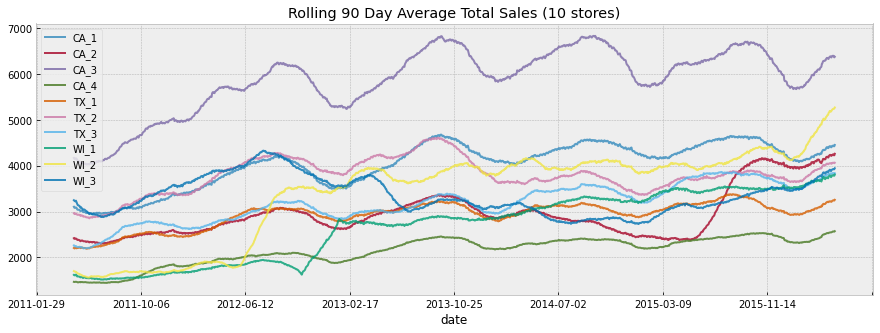

In [0]:
store_list = sellp['store_id'].unique()
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    past_sales[store_items] \
        .sum(axis=1) \
        .rolling(90).mean() \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Rolling 90 Day Average Total Sales (10 stores)')
plt.legend(store_list)
plt.show()

Looking at the same data a different way, we can plot a rolling 7 day total demand count by store. Note clearly that some stores have abrupt changes in their demand, it could be that the store expanded or a new competitor was built near by. Either way this is imporant to note when creating predictive models about demand pattern. 

上では日毎にデータを表示していましたが、次は週ごとに出して見ましょう。
いくつかの店舗は急激な売上の変化がある事がわかります。これはおそらく店舗の増築や競合他社の店舗が近くにできたことに起因するのでしょう。
どちらにしても、売上予測のモデルを作る際にこの急激な変化を加味することが重要になってきます。

In [0]:
fig, axes = plt.subplots(5, 2, figsize=(15, 10), sharex=True)
axes = axes.flatten()
ax_idx = 0
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    #その店舗にある商品idの配列をとっています。
    past_sales[store_items] \
        .sum(axis=1) \
        .rolling(7).mean() \
        .plot(alpha=1,
              ax=axes[ax_idx],
              title=s,
              lw=3,
              color=next(color_cycle))
    #past salesは商品の売上データを時系列グラフで表現しやすいように転置、カレンダーデータとjoinしたものです。
    #その日の商品の売上の合計をだし、
    #rolling 7をすることでその日から一週間前までの売上の平均ととっています。
    ax_idx += 1
# plt.legend(store_list)
plt.suptitle('Weekly Sale Trends by Store ID')
plt.tight_layout()
plt.show()

# Sales Heatmap Calendar

売り上げのヒートマップ表示

In [0]:
# ----------------------------------------------------------------------------
# Author:  Nicolas P. Rougier
# License: BSD
# ----------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from datetime import datetime
from dateutil.relativedelta import relativedelta


def calmap(ax, year, data):
    ax.tick_params('x', length=0, labelsize="medium", which='major')
    ax.tick_params('y', length=0, labelsize="x-small", which='major')

    # Month borders
    xticks, labels = [], []
    start = datetime(year,1,1).weekday()
    for month in range(1,13):
        first = datetime(year, month, 1)
        last = first + relativedelta(months=1, days=-1)

        y0 = first.weekday()
        y1 = last.weekday()
        x0 = (int(first.strftime("%j"))+start-1)//7
        x1 = (int(last.strftime("%j"))+start-1)//7

        P = [ (x0,   y0), (x0,    7),  (x1,   7),
              (x1,   y1+1), (x1+1,  y1+1), (x1+1, 0),
              (x0+1,  0), (x0+1,  y0) ]
        xticks.append(x0 +(x1-x0+1)/2)
        labels.append(first.strftime("%b"))
        poly = Polygon(P, edgecolor="black", facecolor="None",
                       linewidth=1, zorder=20, clip_on=False)
        ax.add_artist(poly)
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(labels)
    ax.set_yticks(0.5 + np.arange(7))
    ax.set_yticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
    ax.set_title("{}".format(year), weight="semibold")
    
    # Clearing first and last day from the data
    valid = datetime(year, 1, 1).weekday()
    data[:valid,0] = np.nan
    valid = datetime(year, 12, 31).weekday()
    # data[:,x1+1:] = np.nan
    data[valid+1:,x1] = np.nan

    # Showing data
    ax.imshow(data, extent=[0,53,0,7], zorder=10, vmin=-1, vmax=1,
              cmap="RdYlBu_r", origin="lower", alpha=.75)
# 軸と年数とデータを渡せばヒートマップを作ってくれるメソッドです。

It appears that walmarts are closed on Chirstmas day. The highest demand day of all the data was on Sunday March 6th, 2016. What happened on this day you may ask... well the [Seventh Democratic presidential candidates debate hosted by CNN and held in Flint, Michigan](https://www.onthisday.com/date/2016/march/6)... I doubt that impacted sales though :D

walmartはクリスマスにしまっていることがわかりました。
また、与えられたデータの期間の中でもっとも商品の需要があった日は2016/3/6の日曜日です。
なぜその日に需要がそんなに高いのかきになると思いますが...あまりいい情報は得られませんでした(笑)

In [0]:
print('The lowest sale date was:', past_sales.sum(axis=1).sort_values().index[0])
print('The highest sale date was:', past_sales.sum(axis=1).sort_values(ascending=False).index[0])

In [0]:
from sklearn.preprocessing import StandardScaler
sscale = StandardScaler()
past_sales.index = pd.to_datetime(past_sales.index)
for i in stv['cat_id'].unique():
    fig, axes = plt.subplots(3, 1, figsize=(15, 5))
    items_col = [c for c in past_sales.columns if i in c]
    sales2013 = past_sales.loc[past_sales.index.isin(pd.date_range('31-Dec-2012',
                                                                   periods=371))][items_col].mean(axis=1)
    vals = np.hstack(sscale.fit_transform(sales2013.values.reshape(-1, 1)))
    calmap(axes[0], 2013, vals.reshape(53,7).T)
    sales2014 = past_sales.loc[past_sales.index.isin(pd.date_range('30-Dec-2013',
                                                                   periods=371))][items_col].mean(axis=1)
    vals = np.hstack(sscale.fit_transform(sales2014.values.reshape(-1, 1)))
    calmap(axes[1], 2014, vals.reshape(53,7).T)
    sales2015 = past_sales.loc[past_sales.index.isin(pd.date_range('29-Dec-2014',
                                                                   periods=371))][items_col].mean(axis=1)
    vals = np.hstack(sscale.fit_transform(sales2015.values.reshape(-1, 1)))
    calmap(axes[2], 2015, vals.reshape(53,7).T)
    plt.suptitle(i, fontsize=15, x=0.3, y=0.98)
    plt.tight_layout()
    plt.show()

ヒートマップを見て気づいたことを列挙したいと思います。
- やはり土日の売り上げが高いです。
- 一月の平日が明らかに低いです。
- ほとんどの場合、火曜から木曜は低いです(ところどころ高いところは祝日の可能性があります。)

# Sale Prices
We are given historical sale prices of each item. Lets take a look at our example item from before.
- It looks to me like the price of this item is growing.
- Different stores have different selling prices.

販売価格
それぞれの商品の販売単価の推移がデータに含まれています。先ほど選んだ商品について、どのように推移していくかを見ていきましょう。
- この商品の販売価格は徐々に上がってきていることがわかる。
- 店舗ごとに違う値段をつけていることがわかる。

In [0]:
fig, ax = plt.subplots(figsize=(15, 5))
stores = []
for store, d in sellp.query('item_id == "FOODS_3_090"').groupby('store_id'):
    d.plot(x='wm_yr_wk',
          y='sell_price',
          style='.',
          color=next(color_cycle),
          figsize=(15, 5),
          title='FOODS_3_090 sale price over time',
         ax=ax,
          legend=store)
    stores.append(store)
    # まず、商品IDで絞り込み、店ごとにgroupbyします。
    # 販売価格をそれぞれプロットします。
    plt.legend()
plt.legend(stores)
plt.show()

In [0]:
sellp['Category'] = sellp['item_id'].str.split('_', expand=True)[0]
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
i = 0
for cat, d in sellp.groupby('Category'):
    ax = d['sell_price'].apply(np.log1p) \
        .plot(kind='hist',
                         bins=20,
                         title=f'Distribution of {cat} prices',
                         ax=axs[i],
                                         color=next(color_cycle))
    # 販売単価をカテゴリーごとにgroup byする。
    # 販売単価を自然対数を底にlogをとり、どの金額範囲にどの程度の商品数が分布しているかを表示している。
    ax.set_xlabel('Log(price)')
    i += 1
plt.tight_layout()

# A simple submission
- Submit the average value from the past 30 days

先月の平均を予測として出したいと思います。

In [0]:
thirty_day_avg_map = stv.set_index('id')[d_cols[-30:]].mean(axis=1).to_dict()
fcols = [f for f in ss.columns if 'F' in f]
for f in fcols:
    ss[f] = ss['id'].map(thirty_day_avg_map).fillna(0)
    
ss.to_csv('submission.csv', index=False)

## TODO
- Simple prediction based on historical average sale by day of week
- Facebook prophet model
- lgbm/xgb model based on day features

TODO
- その曜日の平均売り上げに基づいた簡単な予測の作成
- facebookのprophetを用いたモデル
- lgbm/xgbでの予想

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
from sklearn import preprocessing, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Dropout
from keras.layers import RepeatVector,TimeDistributed
from numpy import array
from keras.models import Sequential, load_model
#import utils_paths
import re
from tqdm import tqdm
import os

In [0]:
train_sales = stv
calendar = cal
sellp = pd.read_csv(f'{INPUT_DIR}/sell_prices.csv')
sell_prices = sellp
submission_file = ss

In [0]:
def transform(data):
    
    nan_features = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in nan_features:
        data[feature].fillna('unknown', inplace = True)
        
    cat = ['event_name_1','event_type_1','event_name_2','event_type_2','snap_CA','snap_TX','snap_WI']
    for feature in cat:
        encoder = preprocessing.LabelEncoder()
        data[feature] = encoder.fit_transform(data[feature])
    
    return data
#calendarの何もない日をunknownで埋めて、label encoderによって処理しやすい形に変えた。

In [0]:
days = range(1, 1970)
time_series_columns = [f'd_{i}' for i in days]
transfer_cal = pd.DataFrame(calendar[['event_name_1','event_type_1','event_name_2','event_type_2','snap_CA','snap_TX','snap_WI']].values.T, index=['event_name_1','event_type_1','event_name_2','event_type_2','snap_CA','snap_TX','snap_WI'], columns= time_series_columns)
transfer_cal = transfer_cal.fillna(0)
event_name_1_se = transfer_cal.loc['event_name_1'].apply(lambda x: x if re.search("^\d+$", str(x)) else np.nan).fillna(10)
event_name_2_se = transfer_cal.loc['event_name_2'].apply(lambda x: x if re.search("^\d+$", str(x)) else np.nan).fillna(10)
#↑event nameが入っているものをnanにした後、10にしている。

In [0]:
calendar['date'] = pd.to_datetime(calendar['date'])
calendar = calendar[calendar['date']>= '2016-1-27']  #reduce memory
#使うデータを少なくします。
calendar= transform(calendar)
# Attempts to convert events into time series data.
transfer_cal = pd.DataFrame(calendar[['event_name_1','event_type_1','event_name_2','event_type_2','snap_CA','snap_TX','snap_WI']].values.T,
                            index=['event_name_1','event_type_1','event_name_2','event_type_2','snap_CA','snap_TX','snap_WI'])
transfer_cal

In [0]:
price_fea = calendar[['wm_yr_wk','date']].merge(sell_prices, on = ['wm_yr_wk'], how = 'left')
#販売価格に対して、calendarを結合した。
price_fea['id'] = price_fea['item_id']+'_'+price_fea['store_id']+'_validation'
df = price_fea.pivot('id','date','sell_price')
#各商品を一行にして、商品の値段の移り変わりを表した。

In [0]:
price_df = train_sales.merge(df,on=['id'],how= 'left').iloc[:,-145:]
price_df.index = train_sales.id
price_df.head()
#train salesに値段の移り変わりをのデータをjoinした。

In [0]:
days = range(1, 1913 + 1)
time_series_columns = [f'd_{i}' for i in days]
time_series_data = train_sales[time_series_columns]  #Get time series data
#train_salesから売り上げデータのみを抽出

In [0]:
#show last 28days
figsize = (25, 5)
time_series_data.iloc[15, -28:].plot(figsize=figsize)
#15行目の最新28日の売り上げデータを表示している。
plt.grid()
#The last 28 days
print(time_series_data.iloc[0, 1885:].shape)

商品の価格と売り上げの関係性をみる

In [0]:
def min_max(df):
    return (df-df.mean())/df.std()  #scale

In [0]:
for i in range(2,6):
    price_sell = calendar.merge(sell_prices[sell_prices.item_id=='HOBBIES_1_00'+str(i)][sell_prices.store_id=='CA_1'], on = ['wm_yr_wk'], how = 'left')
    #商品の絞り込みを行う
    fig =plt.figure(figsize= (20, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(min_max(time_series_data.iloc[i].values))
    ax.plot(min_max(price_sell.sell_price),'-o')
    plt.legend(['sale','price'])
    ax.set_title(str(i))
    ax.set_xlabel('Time')
    ax.set_ylabel('Sales')

商品の価格と売り上げの間には明確な関係が無いように感じる。

売り上げとイベントの関係性をみる。

In [0]:
for i in range(5,10):
    fig =plt.figure(figsize= (20, 5))
    ax = fig.add_subplot(1, 1, 1)
    #ax.bar(x = range(len(transfer_cal.loc['snap_WI'][1500:1800].values)),height = transfer_cal.loc['snap_TX'][1500:1800].values,label='snap_TX',facecolor='red')
    ax.plot(time_series_data.iloc[i, 500:800].values,label='sales')
    #5番目から10番目までの商品について、売上とイベントの相関を示している。
    ax.bar(x = range(300),height = event_name_1_se[500:800].values*0.05*time_series_data.iloc[i, 500:800].values.max(),label='type_1',facecolor='black',width=1.2)
    ax.bar(x = range(300),height = event_name_2_se[500:800].values*0.05*time_series_data.iloc[i, 500:800].values.max(),label='type_2',facecolor='orange',width=1.2)
    plt.legend(['sale','event_1','event_2'])
    ax.set_title(str(i))

    ax.set_xlabel('Time')
    ax.set_ylabel('Sales')

単体の商品にまで絞り込んでしまうと相関性が見辛い

それぞれのカテゴリー配下の商品の売上を比べてみる。
それぞれのカテゴリー配下の売上の分散をみる必要がある。

In [0]:
for i in train_sales.cat_id.unique():
    fig =plt.figure(figsize= (20, 5))
    for j in range(10):
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(train_sales[train_sales.cat_id==i].iloc[j, :][time_series_columns].values)
        #売上データからカテゴリーidで絞り込む
        #絞り込まれた商品データの上から10個の商品の値段の移り変わりを
        ax.set_title(str(i))
        ax.set_xlabel('Time')
        ax.set_ylabel('Sales')

同じカテゴリーの商品でも売上の変化が激しいものとどうではいものが存在するように見える。
しかし、これをそれぞれの商品のmin-maxで[1, 0]にすると似た形なる可能性もある。

In [0]:
for i in train_sales.dept_id.unique():
    fig =plt.figure(figsize= (20, 5))
    for j in range(10):
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(train_sales[train_sales.dept_id==i].iloc[j, :][time_series_columns].values)
        ax.set_title(str(i))
        ax.set_xlabel('Time')
        ax.set_ylabel('Sales')
#商品のカテゴリーをもう少し詳しく分けた部門について、上のカテゴリーと同じように売上の変化グラフをだす。
#部門ごとにみることによって、カテゴリー毎の売上のばらつきがどの部門の商品に起因したものであったのかがわ

In [0]:
for i in train_sales.store_id.unique():
    fig =plt.figure(figsize= (20, 5))
    for j in range(10):
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(train_sales[train_sales.store_id==i].iloc[j, :][time_series_columns].values)
        ax.set_title(str(i))
        ax.set_xlabel('Time')
        ax.set_ylabel('Sales')
#店毎に売上の変化を見ている。


これらをみることによって、dept_idによって売上数は大きく変化することがわかった。

LSTM modelの作成
- lstmとdense層で構成します
- inputに使うのは二つの特徴量のみで、日数は56日間のみにします。

In [0]:

X = []   #build a data with two features(salse and event1)
# 売上データとevent1のデータのみを格納する。
for i in tqdm(range(time_series_data.shape[0])):#30490列について、プログレスバー付きの繰り返しを行う
    X.append([list(t) for t in zip(transfer_cal.loc['event_name_1'][-(100+28):-(28)],
                                   transfer_cal.loc['event_type_1'][-(100+28):-(28)],
                                   transfer_cal.loc['event_name_2'][-(100+28):-(28)],     #emmmm.....Those features didn't work for me...
                                   transfer_cal.loc['event_type_2'][-(100+28):-(28)],
                                   transfer_cal.loc['snap_CA'][-(100+28):-(28)],
                                   transfer_cal.loc['snap_TX'][-(100+28):-(28)],
                                   transfer_cal.loc['snap_WI'][-(100+28):-(28)],
                                   price_df.iloc[i][-(100+28):-(28)],
                                   time_series_data.iloc[i][-100:])]) 
    #for t in zip(A, B, C, ...)によって、A, B, C, ...の要素それぞれの抽出を順番に行なっている
    #transfer colはtrainをlabel encodingしたもの
    #price dfは商品毎の値段の移り変わりを表したもの
    #time_series_dataはその商品の売上を表したもの
    #行列の形は次のようになっている。
    #まず、商品毎の軸が存在する
    #商品毎に次のデータが入れられる
    #日付毎に行列が用意される
    #その日付のカレンダー情報、その日の価格、売上が入れられる。
    
    #todo 特徴量を増やしつつ減らす
    #まずstoreとcatのidは大事これは入れる
    #stateも次くらいに大事
    
X = np.asarray(X, dtype=np.float32)

In [0]:
transfer_cal.loc['event_name_1'][-(100+28):-(28)]

In [0]:
transfer_cal.head(50)

データが大きいため、正規化をする必要があります。
low, highという変数は、train dataを普通のサイズに戻す時の為に保持しています。

In [0]:

def Normalize(list):
    list = np.array(list)
    #配列の状態から行列に変換
    low, high = np.percentile(list, [0, 100])#todo ここの細かい動きが追えていない
    delta = high - low
    if delta != 0:
        for i in range(0, len(list)):
            list[i] = (list[i]-low)/delta
    return  list,low,high
#[0 1]に変換

def FNoramlize(list,low,high):
    delta = high - low
    if delta != 0:
        for i in range(0, len(list)):
            list[i] = list[i]*delta + low
    return list
#normalizeされた値を元に戻す

def Normalize2(list,low,high):
    list = np.array(list)
    delta = high - low
    if delta != 0:
        for i in range(0, len(list)):
            list[i] = (list[i]-low)/delta
    return  list


![](https://ae01.alicdn.com/kf/H0d1d47c633fb4964804a53d6ad248967T.jpg)
timedistributed layerはone to manyもしくはmany to manyの構造を加えます。これによって、modelの次元を増やします。

# timedistributed layer
[公式document](https://keras.io/ja/layers/wrappers/)を参考にtimedistributed layerの説明をしていきたいと思います。
このラッパーによって、入力の全ての時間スライスにレイヤーを適用できる。
入力は少なくとも三次元である必要があり、indexの次元は時間次元と見なされる。

公式document上では、32個のサンプルを持つバッチを考えている。各サンプルでは16次元で構成される10個のベクトルをもつ。
このバッチの入力のshapeは(32, 10, 16)となる。
この時10個のタイムスタンプのレイヤーそれぞれにdenseを適用するためにTimeDistributedを利用できる。

今回の例では30490個のサンプルを持つ。各サンプルは9次元で構成される56個のベクトルを持っている。今回の場合のshapeは(30490, 56, 9)となる。よって、56のタイムスタンプレイヤーそれぞれにdenseを適用するためにtimeDistriibutedを利用することができる。



## repeat vector
n回入力を繰り返します。

*    That is, one output for each LSTM at each input sequence time step rather than one output for each LSTM for the whole input sequence.

*    An output for each step of the input sequence gives the decoder access to the intermediate representation of the input sequence each step. This may or may not be useful. Providing the final LSTM output at the end of the input sequence may be more logical as it captures information about the entire input sequence, ready to map to or calculate an output.


In [0]:
np.random.seed(7)

 ## I only use the last 56 days for train_data.
if __name__ == '__main__':
    n_steps = 28
    train_n,train_low,train_high = Normalize(X[:,-(n_steps*2):,:])
    #Xのデータのうち、56日間のみのデータを抽出、それをNormalizeする。
    X_train = train_n[:,-28*2:-28,:]
    #56日前から28日前までを選択
    y = train_n[:,-28:,8]  #ここには全種類の商品の28日間の売上の情報のみ抽出
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    n_features = 9
    n_out_seq_length =28
    num_y = 1
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
    y = y.reshape((y.shape[0], y.shape[1], 1))
    print(X_train.shape)
    # define model

    model = Sequential()

    
    model.add(LSTM(128, activation='relu', input_shape=(28, n_features),return_sequences=False))
    model.add(RepeatVector(n_out_seq_length))
    model.add(LSTM(32, activation='relu',return_sequences=True))
   #model.add(Dropout(0.1))  
    model.add(TimeDistributed(Dense(num_y)))   # num_y means the shape of y,in some problem(like translate), it can be many.
                                                #In that case, you should set the  activation= 'softmax'
    model.compile(optimizer='adam', loss='mse')
    # demonstrate prediction
    model.fit(X_train, y, epochs=10, batch_size=1000)

submission.csvの作成

In [0]:
num = 30490 # number of traindata
x_input = array(X_train[:,-n_steps*1:])
x_input = x_input.reshape((num, n_steps*1, n_features))
#x_trainはもともと未来28日分までのデータを持っている。それをinputデータとした
print(x_input.shape)
#x_input = Normalize2(x_input,train_low,train_high)
yhat = model.predict(x_input[:,-n_steps:], verbose=0)
x_input=np.concatenate((x_input[:,:,8].reshape(x_input.shape[0],x_input.shape[1]),yhat.astype(np.float32).reshape(x_input.shape[0],x_input.shape[1])),axis=1).reshape((x_input.shape[0],x_input.shape[1]+28,1))
#print(yhat)
print(x_input.shape)
x_input = FNoramlize(x_input,train_low,train_high)
x_input = np.rint(x_input)
#整数にしている
forecast = pd.DataFrame(x_input.reshape(x_input.shape[0],x_input.shape[1])).iloc[:,-28:]
forecast.columns = [f'F{i}' for i in range(1, forecast.shape[1] + 1)]
forecast[forecast < 0] =0
forecast.head()
validation_ids = train_sales['id'].values
evaluation_ids = [i.replace('validation', 'evaluation') for i in validation_ids]
ids = np.concatenate([validation_ids, evaluation_ids])
predictions = pd.DataFrame(ids, columns=['id'])
forecast = pd.concat([forecast]*2).reset_index(drop=True)
predictions = pd.concat([predictions, forecast], axis=1)
predictions.to_csv('submission.csv', index=False)  #Generate the csv file.

# 結論
encode-decode modelといくつかの特徴量を用いたが、大幅な改善は得られなかった

# 個人的todo
- lightGBMを試す
- xgb boostを試す。
- ちょうど一年前の情報も含める
- もしくはちょうど一年前の情報のみを用いる
- LSTMに他の特徴量を突っ込む
- 祝日のデータを入れる

ここから先は日本語訳ではなく、個人的な開発になります。
開発方針としてはLSTMの説明変数の修正
xgboost, lightgbmとのアンサンプル学習
を主に行なっていきたいと思います。

# lightgbm
決定木をベースにしたアルゴリズム
いくつかの弱学習機を作り、それを統合することで一つのモデルを作成するアンサンプル学習を行なっている。
また、似た手法としてxgboostが存在する。


In [0]:
import xgboost as xgb
import lightgbm as lgb

In [0]:
train_sales = stv
calendar = cal
sellp = pd.read_csv(f'{INPUT_DIR}/sell_prices.csv')
sell_prices = sellp
submission_file = ss